# Davis-Panas-Zariphopoulou model

This notebook presents a model for pricing options in a market with proportional transaction costs. The model is taken from the celebrated work of Davis-Panas-Zariphopoulou 1993 [*link-to-the-paper*](https://web.ma.utexas.edu/users/zariphop/pdfs/TZ-7.pdf). 

#### This is a very powerful model!

However, due to its complexity (and time complexity), it is not very well known to the practitioners.

The purpose of this notebook is to explain **in simple terms** the main ideas of the model, and show how to implement it numerically. **The results will surprise you!**

## Contents
   - [Model description](#sec1)
      - [Portfolio dynamics (original)](#sec1.1)
      - [Some definitions](#sec1.2)
   - [Singular control problem](#sec2)
      - [Maximization problem](#sec2.1)
      - [Indifference pricing](#sec2.2)
   - [Variable reduction](#sec3)
      - [Minimization problem](#sec3.1)
      - [Portfolio dynamics (2 state variables)](#sec3.2)
      - [HJB variational inequality](#sec3.3)
      - [Indifference price (explicit form)](#sec3.4)
   - [Numerical Solution](#sec4)
       - [Discrete SDE](#sec4.1)
       - [Algorithm](#sec4.2)
   - [Numerical Computations](#sec5)
       - [Time complexity](#sec5.1)
       - [Is the risk aversion important?](#sec5.2)
       - [Is the drift important?](#sec5.3)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
%matplotlib inline

<a id='sec1'></a>
# Model Description

<a id='sec1.1'></a>
### Portfolio dynamics (original)
Let us consider a portfolio composed by: 
- A bank account $\mathbf{B}$ paying an interest rate $r > 0$. 
- A stock $\mathbf{S}$. 
- A number of shares $\mathbf{Y}$ of the stock $\mathbf{S}$. 

The 3-D state of the portfolio at time $t\in [t_0,T]$ is $(B_t,Y_t,S_t)$ and evolves following the SDE:

\begin{equation}
 \begin{cases}
 dB_t &=  rB_t dt - (1+\theta_b)S_{t} dL_t + (1-\theta_s) S_{t} dM_t \\
 dY_t &=  dL_t - dM_t \\
 dS_t &=  S_{t} \left( \mu dt + \sigma dW_t \right).
\end{cases}
\end{equation} 

The parameters $\theta_b$, $\theta_s \geq 0$ are the proportional transaction costs when buying and selling respectively. 

The processes  $\{(L_t, M_t)\}_{t \in [t_0,T]}$ are the **trading strategies**, i.e. the **controls** of the problem. 

The process $\{L_t\}_{t}$ represents the cumulative number of shares bought up to time $t$, and $\{M_t\}_{t}$ represents the number of shares sold up to time $t$. 
They are right-continuous, finite variation, non-negative and increasing processes. If the time $t$ is a discontinuous point (there is a transaction), the variation of the processes are indicated as
$$ \Delta L_t= L(t)-L(t^-) \quad \quad \Delta M_t= M(t)-M(t^-) $$

Let us consider an example. If at time $t$, the investor wants to buy $\Delta L_t$ shares. Then the portfolio changes as

$$ \Delta Y_t =  \underbrace{\Delta L_t}_{\mbox{shares bought}} \quad \quad
 \Delta B_t =  - \underbrace{(1+\theta_b)S_t}_{\mbox{adjusted price}} \Delta L_t $$

where the **adjusted price** is the real cost of the stock (incorporating the transaction cost).

If there are no transactions, the portfolio has the simple well known evolution:

$$
 \begin{cases}
 dB_t &=  rB_t dt \\
 dY_t &=  0 \\
 dS_t &=  S_{t} \left( \mu dt + \sigma dW_t \right).
\end{cases}
$$


<a id='sec1.2'></a>
### Some definitions

1. The **cash value** function $c(y,s) : \mathbb{R} \times \mathbb{R}^+ \to \mathbb{R}$, is defined as the value in cash when the shares in the portfolio are liquidated i.e.  
long positions are sold and short positions are covered.

\begin{equation}
c(y,s) := \begin{cases} 
(1+\theta_b)ys, & \mbox{if } y\leq 0 \\ 
(1-\theta_s)ys, & \mbox{if } y>0 . 
\end{cases} 
\end{equation}


2. For $t\in [t_0,T]$, the **total wealth** process in a portfolio with zero options is defined as:

\begin{equation}
 \mathcal{W}^0_t := B_t + c(Y_t,S_t).
\end{equation} 


3. If the portfolio contains an option with maturity $T$ and strike $K$, then the wealth process becomes:
 * Writer:
 
 $$\mathcal{W}^{w}_t = \; B_t + c(Y_t,S_t) \mathbb{1}_{\{t < T\}}
   + c(Y_t,S_t) \mathbb{1}_{\{t = T,\, S_t(1+ \theta_b ) \leq K\}}
   + \biggl( c\bigl( Y_t-1,S_t \bigr) + K \biggr) \mathbb{1}_{\{t=T,\, S_t(1+ \theta_b ) > K \}} $$
 
 * Buyer:   
 
 $$  \mathcal{W}^{b}_t = \; B_t + c(Y_t,S_t) \mathbb{1}_{\{t < T\}}
   + c(Y_t,S_t) \mathbb{1}_{\{t = T,\, S_t(1+ \theta_b ) \leq K\}}
   + \biggl( c\bigl( Y_t+1,S_t \bigr) - K \biggr) \mathbb{1}_{\{t=T,\, S_t(1+ \theta_b ) > K \}} $$
  
For $t_0 \leq t<T$, the wealths $\mathcal{W}^{w}_t$ and $\mathcal{W}^{b}_t$ are equal to $\mathcal{W}^{0}_t$, but when $t = T$ they differ because of the payoff of the option. The writer gives away a share and recives the strike and the buyer receive a share and pays the strike. 

Note that considering a market with transaction costs, implies a different condition for the exercise of the option. Now the buyer should exercise if $S_t(1+ \theta_b ) > K$, because the true price of the share incorporates the value of the transaction costs. Let's see the plot:

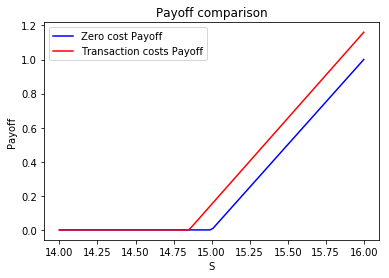

In [2]:
S = np.linspace(14,16,100)
K = 15            # strike
cost_b = 0.01     # transaction cost 

plt.plot(S, np.maximum(S-K,0), color='blue',label="Zero cost Payoff")
plt.plot(S, np.maximum(S*(1+cost_b)-K,0), color='red',label="Transaction costs Payoff")
plt.xlabel("S")
plt.ylabel("Payoff")
plt.title("Payoff comparison")
plt.legend(loc='upper left')
plt.show()

<a id='sec2'></a>
## Singular control problem

<a id='sec2.1'></a>
### Maximization problem

The **value function** of the maximization problem for $j=0,w,b$ (corresponding to the three portfolios: no option, writer, buyer) is defined as:

\begin{equation}
V^j(t,b,y,s) = \sup_{L,M} \;  \mathbb{E}\biggl[ \; \mathcal{U}( \mathcal{W}^{j}_T ) \; \bigg| \; B_{t} = b, Y_{t} = y, S_{t} = s \biggr],             
\end{equation}

where $\mathcal{U}: \mathbb{R} \to \mathbb{R}$ is a concave increasing **utility function**. The **exponential utility** is what we are looking for:

\begin{equation}
 \mathcal{U}(x) := 1- e^{-\gamma x}   \quad \quad \gamma >0 .
\end{equation}

<a id='sec2.2'></a>
### Indifference pricing

The writer (buyer) option price is defined as the amount of cash to add (subtract) to the bank account, 
such that the maximal expected utility of wealth of the writer (buyer) is the same he could get with 
the zero-option portfolio.

* The **writer price** is the value $p^w>0$ such that 
 \begin{equation}
  V^0(t,b,y,s) = V^w(t,b+p^w,y,s),
 \end{equation}
 
* The **buyer price** is the value $p^b>0$ such that
 \begin{equation}
  V^0(t,b,y,s) = V^b(t,b-p^b,y,s).
 \end{equation}

<a id='sec3'></a>
## Variable reduction

Using the properties of the exponential utility, it is possible to remove $\mathbf{B}$ from the state variables.

$$ V^j(t,b,y,s) = \sup_{L,M} \; \mathbb{E}_{t,b,y,s}\biggl[  1- e^{-\gamma \mathcal{W}^j(T) } \biggr]   
	     = 1- e^{-\gamma \frac{b}{\delta(t,T)}} Q^j(t,y,s), $$
         
where $\delta(t,T) = e^{-r(T-t)}$. (for the full calculations, check the paper. Equations 4.21 -4.25).

<a id='sec3.1'></a>
### Minimization problem

\begin{equation}
Q^j(t,y,s) = \inf_{L,M} \; \mathbb{E}_{t,y,s}\biggl[ \;
	     e^{-\gamma \bigl[ -\int_{t}^T (1+\theta_b) \frac{S_u}{\delta(u,T)} dL_u +
	     \int_{t}^T (1-\theta_s) \frac{S_u}{\delta(u,T)} dM_u \bigr] } \; H^j(Y_T,S_T) \bigg]  
\end{equation}

The exponential term inside the expectation can be considered as a discount factor, and the second term is the terminal payoff:
 - No option:
 
 $$ H^0(y,s) = e^{-\gamma \, c(y,s)}. $$
 
 - Writer:
 
 $$ H^w(y,s) = e^{-\gamma \bigl[ c(y,s)\mathbb{1}_{\{s(1+\theta_b) \leq K\}} + 
 \bigl( c( y-1,s) + K \bigr) \mathbb{1}_{\{s(1+\theta_b)>K\}} \bigr] }.$$
 
 - Buyer:

$$  H^b(y,s) = e^{-\gamma \bigl[ c(y,s)\mathbb{1}_{\{s(1+\theta_b) \leq K\}} + 
 \bigl( c( y+1,s) - K \bigr) \mathbb{1}_{\{s(1+\theta_b)>K\}} \bigr] }.
$$

<a id='sec3.2'></a>
### Portfolio dynamics (2 state variables)

In order to simplify the numerical computations,let us pass to the log-variable $X_t = \log(S_t)$.

The resulting portfolio dynamics is:

\begin{equation}
 \begin{cases}
 dY_t &=  dL_t - dM_t \\
 dX_t &= \biggl( \mu - \frac{1}{2} \sigma^2 \biggr) dt + \sigma dW_t.
\end{cases}
\end{equation} 


<a id='sec3.3'></a>
### HJB variational inequality

The Hamilton Jacobi Bellman equation associated to the minimization problem is:

$$
 \min \; \biggl\{ \; \frac{\partial Q^j}{\partial t} + (\mu-\frac{1}{2}\sigma^2) \frac{\partial Q^j}{\partial x}
+ \frac{1}{2}\sigma^2 \frac{\partial^2 Q^j}{\partial x^2}  ,
 \; \frac{\partial Q^j}{\partial y} +(1+\theta_b) e^x \frac{\gamma}{\delta(t,T)}Q^j \; , 
\; -\biggl( \frac{\partial Q^j}{\partial y}+(1-\theta_s)e^x \frac{\gamma}{\delta(t,T)} Q^j 
\biggr) \biggr\} = 0. 
$$

<a id='sec3.4'></a>
### Indifference price (explicit form)

Using again the explicit form of the utility function, we obtain formulas for the option prices:

$$
 p^w(t_0,y,x) = \frac{\delta(t_0,T)}{\gamma} \log \biggl( \frac{Q^w(t_0,y,e^x)}{Q^0(t_0,y,e^x)} \biggr), $$
 
$$ p^b(t_0,y,x) = \frac{\delta(t_0,T)}{\gamma} \log \biggl( \frac{Q^0(t_0,y,e^x)}{Q^b(t_0,y,e^x)} \biggr).
$$

<a id='sec4'></a>
# Numerical Solution

<a id='sec4.1'></a>
###  Discrete SDE

As usual, we introduced the time step $\Delta t = \frac{T}{N}$, where we assumed $t_0 = 0$ and $N \in \mathbb{N}$. 
The time $t_n = n \Delta t$, for $n \in \{0,1,2, ..., N\}$. 

The space discretization has 2 dimensions:
- The space step $h_x$ is defined as $h_x = \sigma \sqrt{\Delta t}$.
- The space step is $h_y$. In this computations we choose $h_x = h_y$.

The discretized version of the Stochastic Differential equation is: 

$$
 \begin{cases}
 \Delta Y_n &= \; \Delta L_n - \Delta M_n \\
 \Delta X_n &= \; (\mu - \frac{1}{2} \sigma^2 )  \Delta t + \sigma \Delta W_n
\end{cases}
$$

Both $\Delta L_n$ and $\Delta M_n$ at each time $t_n$ can assume values in $\{0,h_y\}$. They cannot be different from zero at the same time (It is quite strange to buy and sell at the same time, right?)

The variable $\Delta W_n$ has $\frac{1}{2}$ probability of being equal to $h_x$ and $\frac{1}{2}$ probability of being equal to $-h_x$.

The variation $\Delta X_n$ is $\pm h_x$ plus the drift component. We obtain a recombining **binomial tree**.

### Binomial tree with drift

In [3]:
N = 6; dt=1/N; S0 = 15; x0 = np.log(S0) 
mu = 0.1; sig = 0.25; h_x = sig * np.sqrt(dt)

for n in range(N):
    x = np.array( [x0 + (mu-0.5*sig**2)*dt*n + (2*i-n)*h_x for i in range(n+1) ] )
    print(x)

[2.7080502]
[2.61744646 2.82157061]
[2.52684272 2.73096687 2.93509101]
[2.43623898 2.64036313 2.84448727 3.04861142]
[2.34563524 2.54975939 2.75388353 2.95800768 3.16213182]
[2.2550315  2.45915565 2.6632798  2.86740394 3.07152809 3.27565223]


<a id='sec4.2'></a>
###  Algorithm

Using the Dynamic Programming Principle (DPP) on the minimization problem we obtain a recursive algorithm on the nodes of the grid.

$$ \begin{aligned}
 Q^{j}(t_n,Y_n,X_n) = \min  
 & \; \biggl\{ \mathbb{E}_n \biggl[ Q \bigl( t_{n+1}, Y_n, X_n + \Delta X_n \bigr) \biggr], \\ \nonumber
 & \; \exp \biggl(\frac{\gamma}{\delta(t_n,T)} (1+\theta_b) e^{X_n} \Delta L_n \biggr) 
  \mathbb{E}_n \biggl[ Q^{j} \bigl( t_{n+1}, Y_n+\Delta L_n, X_n + \Delta X_n \bigr) \biggr], \\ \nonumber
 & \; \exp \biggl(\frac{-\gamma}{\delta(t_n,T)} (1-\theta_s) e^{X_n} \Delta M_n \biggr)
  \mathbb{E}_n \biggl[ Q^{j} \bigl( t_{n+1}, Y_n-\Delta M_n, X_n + \Delta X_n \bigr) \biggr]
 \biggr\}.
\end{aligned} $$

#### How to solve this problem?
- Create a **binomial tree** with N time steps. 
- Create a "shares vector" **y** with dimension M. 
- Initialize a two dimensional grid of size $(N+1)\times M$, to be filled with the values of the terminal conditions $H^j(y,e^x)$ for $j=0,w,b$ (see [Minimization problem](#sec3.1))
- Create a backward loop over time and find $Q^j(0,0,X_0)$

#### Computational complexity?  Well... Quite high. 
- A binomial tree with N time steps has $\sum_{n=0}^N (n+1) = \frac{N(N+1)}{2} + (N+1) = (N+1)(\frac{N}{2}+1)$ nodes. 
The loop over all the nodes is $\mathcal{O}(N^2)$.
- If we assume $M \sim N$, the loop over all the values of **y** has another $\mathcal{O}(N)$.
- The minimum search for every point in **y**, produces another $\mathcal{O}(N)$ operations.

Therefore the total computational complexity is of $\mathcal{O}(N^4)$.


#### For space reasons, I will not expose the code here in the notebook. The interested reader can peek the (clear and commented) code inside the class TC_pricer.  [code](./functions/TC_pricer.py)

<a id='sec5'></a>
# Numerical computations

Let us import the classes we need:
 - **Option_param**: creates the option object
 - **Diffusion_process**: creates the process object
 - **TC_pricer**: creates the pricer for this model
 - **BS_pricer**: creates the Black-Scholes pricer, useful for making comparisons.  

In [10]:
from functions.Parameters import Option_param  
from functions.Processes import Diffusion_process
from functions.TC_pricer import TC_pricer
from functions.BS_pricer import BS_pricer

# Creates the object with the parameters of the option
opt_param = Option_param(S0=15, K=15, T=1, exercise="European", payoff="call" )

# Creates the object with the parameters of the process
diff_param = Diffusion_process(r=0.1, sig=0.25, mu=0.1)

# Creates the object of the Transaction Costs pricer
TC = TC_pricer(opt_param, diff_param, cost_b=0, cost_s=0, gamma=0.0001)
# Creates the object of the Black-Scholes pricer
BS = BS_pricer(opt_param, diff_param)

We expect that if the transaction costs are **zero**, and the risk aversion coefficient $\gamma \to 0$ (i.e. the investor becomes risk neutral), the price should **converge** to the **Black-Scholes price**

In [11]:
tc = TC.price(N=2000)
bs = BS.closed_formula()

print("Zero TC price: ", tc )
print("Black Scholes price:", bs )
print("Difference:", np.abs(tc-bs))

Zero TC price:  2.246375063664713
Black Scholes price: 2.246368616746695
Difference: 6.446918018099268e-06


#### Wait a second!!! WE CAN DO BETTER!

##### Let us analyze the the writer and buyer prices, for different initial stock values.

In [29]:
S = list(range(5,21))
price_0 = []; price_w = []; price_b = []

for s in S:
    TC.S0 = s
    TC.cost_b=0; TC.cost_s=0
    price_0.append(TC.price(N=400))   # zero costs
    TC.cost_b=0.05; TC.cost_s=0.05
    price_w.append(TC.price(N=400, TYPE="writer")) 
    price_b.append(TC.price(N=400, TYPE="buyer"))
TC.cost_b=0; TC.cost_s=0  # set to 0 for future computations

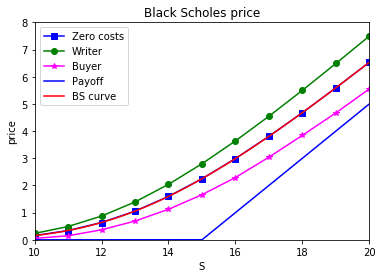

In [33]:
plt.plot(S,price_0, color='blue', marker='s',label="Zero costs")
plt.plot(S,price_w, color='green', marker='o',label="Writer")
plt.plot(S,price_b, color='magenta', marker='*',label="Buyer")
BS.plot(axis=[10,20,0,8])  #plot of the Black Scholes line

<a id='sec5.1'></a>
### Time complexity

If we set the "Time" argument to True, the method also returns the execution time.
Let us verify that the algorithm has time complexity of order $\mathcal{O}(N^4)$

The following operation will be very time consuming. In case you are in a hurry, reduce the NUM.

In [8]:
NUM = 7
price_table = pd.DataFrame(columns=['N', "Price", "Time"])
for j,n in enumerate([50 * 2**i for i in range(NUM) ]):
    price_table.loc[j] = [n] + list(TC.price(n,Time=True))
display(price_table)

,N,Price,Time
0,50.0,2.241215,0.033321
1,100.0,2.249143,0.096112
2,200.0,2.245423,0.395083
3,400.0,2.246784,1.948342
4,800.0,2.246289,13.928330
5,1600.0,2.246577,111.881915
6,3200.0,2.246412,1607.674912


Using the computational times we can estimate the exponent $\alpha$ of the polinomial growth $\mathcal{O}(N^\alpha)$. 

For higher values of N, the exponent converges to the expected value of $\alpha = 4$.

Here we are quite close.

In [27]:
print("The exponent is: ", np.log2(price_table["Time"][6]/price_table["Time"][5]))

The exponent is:  3.8449269495846137


<a id='sec5.2'></a>
### Is the risk aversion important?

The coefficient $\gamma$ measure the risk aversion of the investor. We can see how the option price is affected by this coefficient:

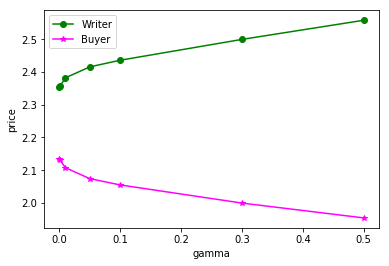

In [18]:
price_ww = []; price_bb = []; gammas = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.3, 0.5]
TC.cost_b=0.01; TC.cost_s=0.01

for gamma in gammas:
    TC.gamma = gamma
    price_ww.append(TC.price(N=400, TYPE="writer")) 
    price_bb.append(TC.price(N=400, TYPE="buyer"))

plt.plot(gammas, price_ww, color='green', marker='o',label="Writer")
plt.plot(gammas, price_bb, color='magenta', marker='*',label="Buyer")
plt.xlabel("gamma"); plt.ylabel("price"); plt.legend()
plt.show()

So far we have found that:

- The option pricing is an increasing function of the risk aversion coefficient for the writer, and a decreasing function for the buyer.

- The option pricing is an increasing function of the transaction costs for the writer, and a decreasing function for the buyer.

<a id='sec5.3'></a>
### Is the drift important? 

As we know from the "classical" no-arbitrage martingale pricing theory, the option price does not depend on the stock expected value. 

However, this model is a utility based model i.e. a model that does not consider a risk neutral investor. 

We can see that in this model the option price depends on the drift. 

If we consider a high risk aversion coefficient, the option price is not very sensitive to the drift. If instead we choose a small value of $\gamma$, i.e. the investor is risk neutral, the drift plays the role of the risk neutral expected return $r$ and therefore changing $\mu$, is like changing $r$.

Following Hodges-Neuberger [2], in the practical computations **it is better to set $\mu=r$.**

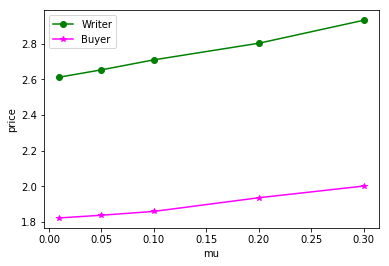

In [36]:
price_mu1 = []; price_mu2 = []; mus = [0.01, 0.05, 0.1, 0.2, 0.3]
TC.gamma = 1 # high value of risk aversion
TC.cost_b=0.01; TC.cost_s=0.01

for mu in mus:
    TC.mu = mu
    price_mu1.append(TC.price(N=400, TYPE="writer")) 
    price_mu2.append(TC.price(N=400, TYPE="buyer"))

plt.plot(mus, price_mu1, color='green', marker='o',label="Writer")
plt.plot(mus, price_mu2, color='magenta', marker='*',label="Buyer")
plt.xlabel("mu"); plt.ylabel("price"); plt.legend()
plt.show()

### Other references

[1] Cantarutti, N., Guerra, J., Guerra, M., and Grossinho, M. (2019). Option pricing in exponential Lévy models with transaction costs. [*ArXiv*](https://arxiv.org/abs/1611.00389). 

[2] Hodges, S. D. and Neuberger, A. (1989). Optimal replication of contingent claims under transaction costs. The Review of Future Markets, 8(2):222–239.